In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
dir <- "environment/real_datasets/GSE100505/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/comp_trees"
term_dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
suppressPackageStartupMessages(source("old_terminus_helper.R"))
suppressPackageStartupMessages(source("tree_helper_function.R"))
load(file.path(dir, "treeCons.RData"))
load(file.path(dir, "yAggConsNS.RData"))
load(file.path(dir, "treeCor.RData"))
load(file.path(dir, "yAggCorNS.RData"))
load(file.path(dir, "treeCons0.RData"))
load(file.path(dir, "yAggConsNS0.RData"))
load(file.path(dir, "treeMeanInf0.RData"))
load(file.path(dir, "yAggMeanInfNS0.RData"))
load(file.path(dir, "treeThr.RData"))
load(file.path(dir, "yAggThrNS.RData"))
load(file.path(dir, "yAggTermThrNS.RData"))
suppressPackageStartupMessages(source("brain_simulation_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/tree_analysis/tree_filter.R"))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(latex2exp))

In [8]:
dfScaledLFC <- data.frame(matrix(nrow=0, ncol=3))
colnames(dfScaledLFC) <- c("Type", "Value", "nCuts")

l <- length(treeCons$tip)
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- c("ConsInd", "Cons", "Mean", "AC", "ConsRedInd", "Term")
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS, yAggTermThrNS)
names(yAgg) <- c("ConsInd", "Cons", "Mean", "AC", "ConsRedInd", "Term")

dCutsSLFC <- vector(mode = "list", length=7)
names(dCutsSLFC) <- c(names(yAgg), "Txps")

for(i in seq_along(yAgg)) {
    globArr <- rep(-100, l+trees[[i]]$Nnode)
    if(i <= 5)
        descL <- sapply(Descendants(trees[[i]], seq(l+trees[[i]]$Nnode)), length)
    else {
        groupsClust <- parseClustFile(file.path(term_dir, "old", "SRR5758702", "clusters.txt"), yAggTermThrNS, gsub=F)
        mtxps <- setdiff(seq(l), unlist(groupsClust))
        dCutsSLFC[[i]] <- c(mtxps, l+1:length(groupsClust))
        descL <- c(rep(1, length(mtxps)), sapply(groupsClust, length))
    }
    infReps <- assays(yAgg[[i]])[grep("infRep", assayNames(yAgg[[i]]))]
    infReps <- abind::abind(as.list(infReps), along = 3)
    mSf <- 0
    for(j in seq(dim(infReps)[3])) {
            sf <- colSums(infReps[1:l,,j])
            mSf <- mean(sf) + mSf
            infReps[,,j] <- t(t(infReps[,,j])/sf)
    }
    mSf <- mSf/dim(infReps)[3]
    print(mSf)
    lfc <- getLog2FC(infReps, colData(yAgg[[i]])[["condition"]], pc = 5/mSf)
    obj <- abs(lfc)/mcols(yAgg[[i]])[["meanInfRV"]]
    if (i==6)         
        val <- sum(obj[dCutsSLFC[[i]]]*descL)

    else {
            val <- findMaxSum(trees[[i]], obj, l+1, descL)
            gc()
            dCutsSLFC[[i]] <- findCuts(trees[[i]], globArr, obj, l+1, descL)
            gc()
    }
    dfScaledLFC <- rbind(dfScaledLFC, data.frame(Type = names(yAgg)[i], Value = val,
           nCuts = length(dCutsSLFC[[i]])))

}
i <- 7
dCutsSLFC[[i]] <- 1:l
val <- sum(obj[dCutsSLFC[[i]]])
dfScaledLFC <- rbind(dfScaledLFC, data.frame(Type = "Txp", Value = val,
           nCuts = length(dCutsSLFC[[i]])))
print(dfScaledLFC)
save(dfScaledLFC, file=file.path(dir, "dfScaledLFC.RData"))
save(dCutsSLFC, file=file.path(dir, "dCutsSLFC.RData"))

        Type     Value  nCuts
1    ConsInd 2697330.9  31482
2       Cons 2942672.0  26103
3       Mean 3089558.1  24737
4         AC 1579921.4  55695
5 ConsRedInd  686372.2  91106
6       Term  511725.3  97690
7        Txp  459809.7 102091


In [3]:
load(file.path(dir, "dfInf.RData"))
load(file.path(dir, "dCutsDInf.RData"))
load(file.path(dir, "dCutsSLFC.RData"))
names(dCutsSLFC)
names(dCutsDInf[[1]])
nn <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES")
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- nn
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS)
names(yAgg) <- nn

[1] "ConsInd"    "Cons"       "Mean"       "AC"         "ConsRedInd"
[6] "Term"       "Txp"

[1] "ConsInd"    "Cons"       "Mean"       "AC"         "ConsRedInd"
[6] "Txps"

In [4]:
l <- length(treeCons$tip)
gammas <- c(0.1,0.5,1,5,10)
objsLFC <- vector(mode="list", length(yAgg))
names(objsLFC) <- names(yAgg)
objsDepth <- vector(mode="list", length(yAgg))
names(objsDepth) <- names(yAgg)
for(i in seq_along(yAgg)) {
    descL <- sapply(Descendants(trees[[i]],seq(l+trees[[i]]$Nnode)),length)
    objsDepth[[i]] <- (mcols(yAgg[[i]])[["meanInfRV"]] + 0.1*node.depth(trees[[i]],2))*descL
    infReps <- assays(yAgg[[i]])[grep("infRep", assayNames(yAgg[[i]]))]
    infReps <- abind::abind(as.list(infReps), along = 3)
    mSf <- 0
    for(j in seq(dim(infReps)[3])) {
            sf <- colSums(infReps[1:l,,j])
            mSf <- mean(sf) + mSf
            infReps[,,j] <- t(t(infReps[,,j])/sf)
    }
    mSf <- mSf/dim(infReps)[3]
    print(mSf)
    lfc <- getLog2FC(infReps, colData(yAgg[[i]])[["condition"]], pc = 5/mSf)
    objsLFC[[i]] <- descL*abs(lfc)/mcols(yAgg[[i]])[["meanInfRV"]]
}

[1] 34098477
[1] 34098477
[1] 34098477
[1] 34098477
[1] 34098477


In [5]:
suppressPackageStartupMessages(source("old_terminus_helper.R"))
i <- 6
infReps <- assays(yAggTermThrNS)[grep("infRep", assayNames(yAggTermThrNS))]
infReps <- abind::abind(as.list(infReps), along = 3)
groupsClust <- parseClustFile(file.path(term_dir, "old", "SRR5758702", "clusters.txt"), yAggTermThrNS, gsub=F)
mtxps <- setdiff(seq(l), unlist(groupsClust))

mSf <- 0
for(j in seq(dim(infReps)[3])) {
            sf <- colSums(infReps[1:l,,j])
            mSf <- mean(sf) + mSf
            infReps[,,j] <- t(t(infReps[,,j])/sf)
    }
mSf <- mSf/dim(infReps)[3]
descL <- c(rep(1, l), sapply(groupsClust, length))


lfc <- getLog2FC(infReps, colData(yAggTermThrNS)[["condition"]], pc = 5/mSf)
objsLFC[[i]] <- descL*abs(lfc)/mcols(yAggTermThrNS)[["meanInfRV"]]
names(objsLFC)[i] <- "Term"

[1] "ConsFilt"

           1            2            3            4            5            6 
7.909963e-01 7.028626e-02 4.996002e-02 3.494323e-02 2.310891e-02 1.340157e-02 
           7            8            9           10           11           12 
7.884216e-03 4.158004e-03 2.478810e-03 1.199424e-03 4.957620e-04 4.797697e-04 
          13           14           15           16           17           19 
2.398849e-04 1.759156e-04 4.797697e-05 6.396929e-05 3.198465e-05 3.198465e-05 
          21 
1.599232e-05 
[1] "Cons"

           1            2            3            4            5            6 
8.015352e-01 6.523012e-02 4.636394e-02 3.278461e-02 2.219551e-02 1.344061e-02 
           7            8            9           10           11           12 
8.200006e-03 4.577823e-03 2.419927e-03 1.587595e-03 5.703012e-04 5.086470e-04 
          13           14           15           16           17           18 
2.466167e-04 1.233084e-04 6.165418e-05 3.082709e-05 3.082709e-05 3.082709e-

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"


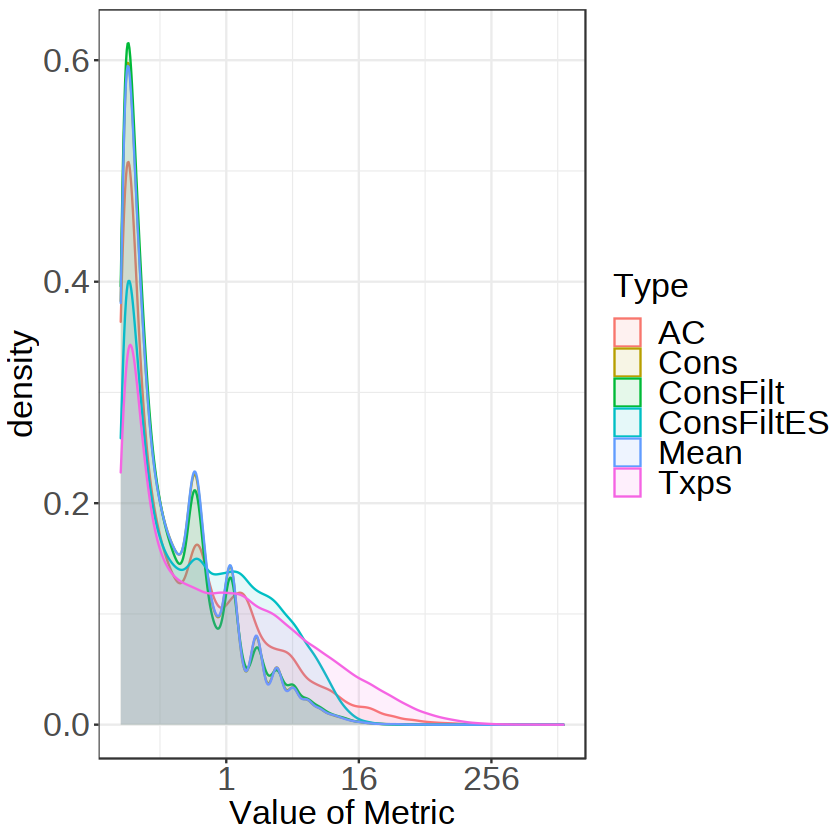

In [7]:
for(i in seq(trees)){
    print(names(trees)[i])
    print(table(node.depth(trees[[i]],2)[dCutsDInf[[1]][[i]]])/length(dCutsDInf[[1]][[i]]))
}
i <- 1
dfDepth <- data.frame(depthObj = objsDepth[[i]][dCutsDInf[[1]][[i]]], type=names(objsDepth)[i])
for(i in seq(2,5)) {
    dfDepth <- rbind(dfDepth, data.frame(depthObj = objsDepth[[i]][dCutsDInf[[1]][[i]]], type=names(objsDepth)[i]))
}
dfDepth <- rbind(dfDepth, data.frame(depthObj = objsDepth[[i]][1:l], type="Txps"))
size <- 20
pBr <- ggplot(dfDepth, aes(x=depthObj, fill = type, colour = type)) + 
    geom_density(position = "dodge", alpha=0.1) +
    theme_bw() +
    scale_x_continuous(trans="log2") +
    labs(fill="Type", color="Type") +
    xlab("Value of Metric") +
    theme(axis.title = element_text(size = size),
    plot.title = element_text(size = size + 1, hjust=0.5),
    axis.text = element_text(size = size),
    legend.text = element_text(size = size),
    legend.title = element_text(size = size))
pBr

[1] "ConsFilt"

           1            2            3            4            5            6 
5.131186e-01 1.261673e-01 8.893971e-02 7.705991e-02 6.086017e-02 4.386634e-02 
           7            8            9           10           11           12 
2.992186e-02 1.921733e-02 1.324566e-02 8.766914e-03 6.797535e-03 3.430532e-03 
          13           14           15           16           17           18 
2.763484e-03 2.287021e-03 1.238803e-03 7.941046e-04 3.494060e-04 1.905851e-04 
          19           20           21           22           23           24 
1.905851e-04 2.223493e-04 1.270567e-04 3.176418e-05 1.270567e-04 3.176418e-05 
          25           26           32           51           56           66 
6.352837e-05 3.176418e-05 3.176418e-05 3.176418e-05 3.176418e-05 3.176418e-05 
         120 
3.176418e-05 
[1] "Cons"

           1            2            3            4            5            6 
3.881546e-01 1.497146e-01 9.600429e-02 8.190629e-02 6.815309e-02 5.256101e-

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"


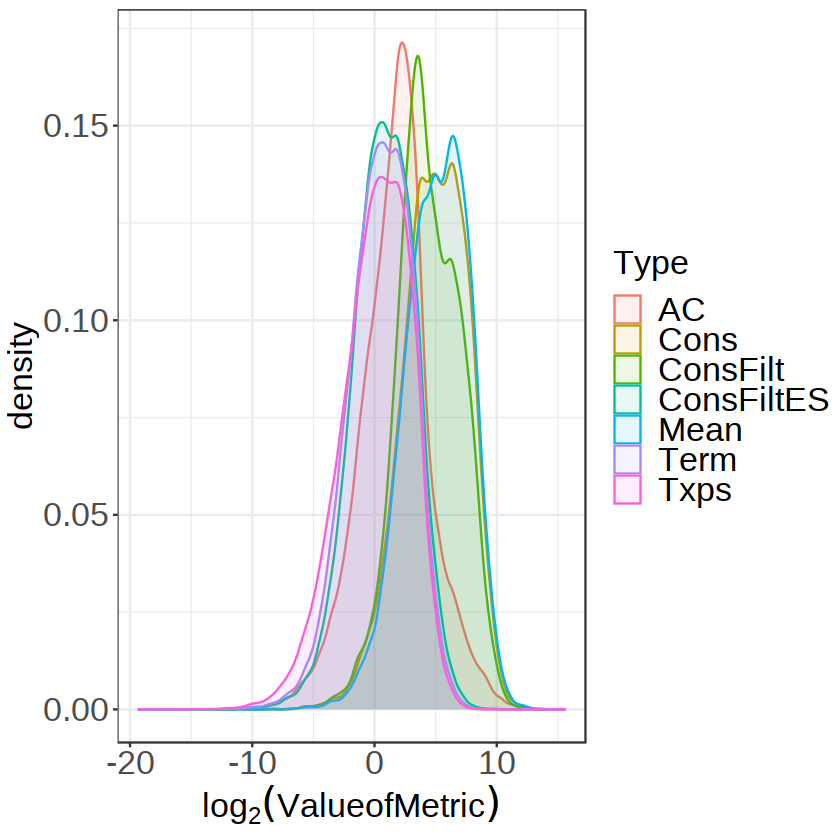

In [10]:
for(i in seq(trees)){
    print(names(trees)[i])
    print(table(node.depth(trees[[i]],2)[dCutsSLFC[[i]]])/length(dCutsSLFC[[i]]))
}
i <- 1
dfLFC <- data.frame(LFC = objsLFC[[i]][dCutsSLFC[[i]]], type=names(objsLFC)[i])
for(i in seq(2,6)) {
    dfLFC <- rbind(dfLFC, data.frame(LFC = objsLFC[[i]][dCutsSLFC[[i]]], type=names(objsLFC)[i]))
}
i <- 7
dfLFC <- rbind(dfLFC, data.frame(LFC = objsLFC[[i-1]][1:l], type="Txps"))
pBr <- ggplot(dfLFC, aes(x=log2(LFC), fill = type, colour = type)) + 
    geom_density(position = "dodge", alpha=0.1) +
    labs(fill="Type", color="Type") +
    xlab(TeX("$log_{2}(Value of Metric)$")) +
    theme_bw() +
    theme(axis.title = element_text(size = size),
    plot.title = element_text(size = size + 1, hjust=0.5),
    axis.text = element_text(size = size),
    legend.text = element_text(size = size),
    legend.title = element_text(size = size))
pBr

In [11]:
save(dfDepth, file=file.path(dir, "dfDe.RData"))
save(dfLFC, file=file.path(dir, "dfLL.RData"))